Probabilistic Programming in 3 Examples
======
______

Probabilistic programming makes Bayesian inference easy to do.  Recent advancements in inference algorithms like NUTS[1] and ADVI[2] have made probabilistic programming a reality.  We will look at 3 examples in PyMC3 to illustrate the use for probabilistic programming.

These examples are taken other brilliant hackers and I take zero credit.  If you have time, I highly recommend reading "Bayesian Methods for Hackers"[3] and "Probabilistic programming in Python using PyMC3"[4].  Thanks to Fast Forward Labs[5] for letting me review their research on the topic.

p.s - if you want to run the code as you go along, I suggest installing the dev version of pymc3 from github (otherwise I ran into performance issues, at least on my 3yo macbook) 

`pip install git+https://github.com/pymc-devs/pymc3`


##### Bayesian Inference and Probabilistic Programming
For the uninitiated, Bayesian inference allows you to build statistical models with ease and quantify uncertainties in your predictions.  It also allows you to specify prior/domain knowledge to influence the predictions.  While still new and not lacking in shortcomings, probabilistic programming gives us great tools for avoiding some common pitfalls in data science.

The following 3 examples will hopefully illustrate the use for this approach.

## Example1: Bayesian A/B testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A vs drug B. The company will test drug A on some fraction of their trials, and drug B on the other fraction (this fraction is often 1/2, but we will relax this assumption). After performing enough trials, the in-house statisticians sift through the data to determine which drug yielded better results. 

Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of visitors to site A, and the other fraction to site B, and record if the visit yielded a sale or not. The data is recorded (in real-time), and analyzed afterwards. 

Often, the post-experiment analysis is done using something called a hypothesis test like *difference of means test* or *difference of proportions test*. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (though not necessarily *learned* this technique). And if you were like me, you may have felt uncomfortable with their derivation -- good: the Bayesian approach to this problem is much more natural. 

#### A Simple Case

For the moment, we will focus on the analysis of site A only. Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site. This is the true effectiveness of site A. Currently, this quantity is unknown to us. 

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the *observed frequency* $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the *observed frequency* and the *true frequency* of an event. The true frequency can be interpreted as the probability of an event occurring. For example, the true frequency of rolling a 1 on a 6-sided die is $\frac{1}{6}$. Knowing the true frequency of events like:

- fraction of users who make purchases, 
- frequency of social attributes, 
- percent of internet users with cats etc. 

are common requests we ask of Nature. Unfortunately, often Nature hides the true frequency from us and we must *infer* it from observed data.

The *observed frequency* is then the frequency we observe: say rolling the die 100 times you may observe 20 rolls of 1. The observed frequency, 0.2, differs from the true frequency, $\frac{1}{6}$. We can use Bayesian statistics to infer probable values of the true frequency using an appropriate prior and observed data.


With respect to our A/B example, we are interested in using what we know, $N$ (the total trials administered) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of buyers, might be. 

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. *A priori*, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [1]:
import pymc3 as pm
import scipy.stats as stats
import numpy as np

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

/Users/erictang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Had we had stronger beliefs, we could have expressed them in the prior above.

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a *Bernoulli* distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate the data.

In [2]:
#set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Remember: Python treats True == 1, and False == 0
print(np.sum(occurrences))

[0 0 0 ..., 0 0 0]
77


The observed frequency is:

In [3]:
# Occurrences.mean is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % occurrences.mean())
print("Does this equal the true frequency? %s" % (occurrences.mean() == p_true))

What is the observed frequency in Group A? 0.0513
Does this equal the true frequency? False


We combine the observations into the PyMC `observed` variable, and run our inference algorithm:

In [4]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|██████████| 18000/18000 [00:01<00:00, 10912.08it/s]


We plot the posterior distribution of the unknown $p_A$ below:

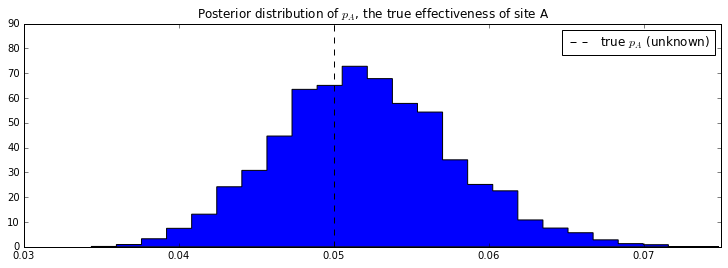

In [5]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend();

Our posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails. This is a measure of how uncertain we should be, given our observations. Try changing the number of observations, `N`, and observe how the posterior distribution changes.

### *A* and *B* Together

A similar analysis can be done for site B's response data to determine the analogous $p_B$. But what we are really interested in is the *difference* between $p_A$ and $p_B$. Let's infer $p_A$, $p_B$, *and* $\text{delta} = p_A - p_B$, all at once. We can do this using PyMC's deterministic variables. (We'll assume for this exercise that $p_B = 0.04$, so $\text{delta} = 0.01$, $N_B = 750$ (significantly less than $N_A$) and we will simulate site B's data like we did for site A's data )

In [6]:
import pymc3 as pm
figsize(12, 4)

#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")

('Obs from Site A: ', array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0]), '...')
('Obs from Site B: ', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0]), '...')


In [7]:
print(observations_A.mean())
print(observations_B.mean())

0.0453333333333
0.0386666666667


In [8]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

100%|██████████| 20000/20000 [00:03<00:00, 5464.06it/s]


Below we plot the posterior distributions for the three unknowns: 

In [9]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

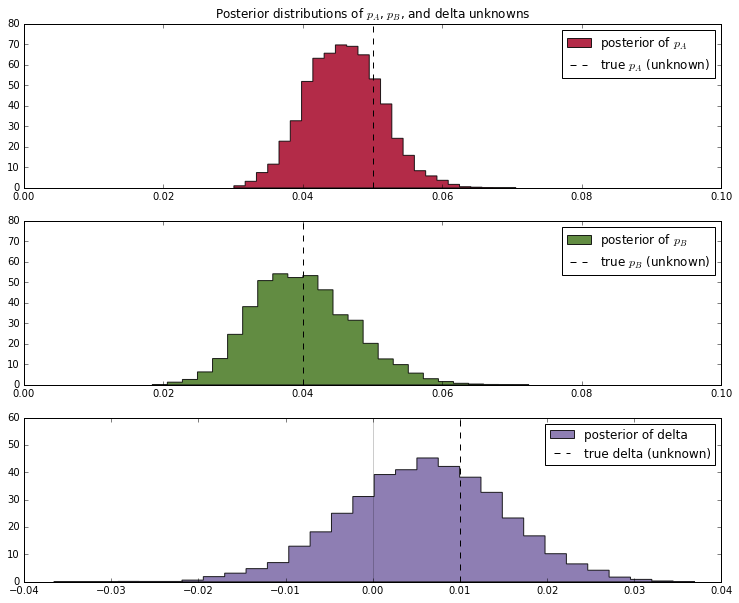

In [10]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Notice that as a result of `N_B < N_A`, i.e. we have less data from site B, our posterior distribution of $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$.  

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, implying there site A's response is likely better than site B's response. The probability this inference is incorrect is easily computable:

In [11]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.252
Probability site A is BETTER than site B: 0.748


If this probability is too high for comfortable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A). 

Try playing with the parameters `true_p_A`, `true_p_B`, `N_A`, and `N_B`, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

I hope the readers feel this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. Later in this book, we will see two extensions of this model: the first to help dynamically adjust for bad sites, and the second will improve the speed of this computation by reducing the analysis to a single equation.   

## Example2: Stock Market Volatility

We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3’s use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

##### The Model

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).

\begin{aligned}
  \sigma &\sim exp(50) \\
  \nu &\sim exp(.1) \\
  s_i &\sim \mathcal{N}(s_{i-1}, \sigma^{-2}) \\
  log(y_i) &\sim t(\nu, 0, exp(-2 s_i))
\end{aligned}

Here, y is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process s. The individual si are the individual daily log volatilities in the latent log volatility process.

##### The Data
Our data consist of daily returns of the S&P 500 during the 2008 financial crisis.

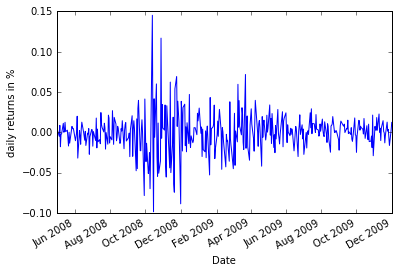

In [2]:
%matplotlib inline

try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas-datareader
    from pandas_datareader import data
    
import pandas as pd
import matplotlib.pyplot as plt

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

returns.plot()
plt.ylabel('daily returns in %');


##### Model Implementation

As with the linear regression example, implementing the model in PyMC3 mirrors its statistical specification. This model employs several new distributions: the Exponential distribution for the ν and σ priors, the Student-T (StudentT) distribution for distribution of returns, and the GaussianRandomWalk for the prior for the latent volatilities.

In PyMC3, variables with positive support like Exponential are transformed with a log transform, making sampling more robust. Behind the scenes, the variable is transformed to the unconstrained space (named “variableName_log”) and added to the model for sampling. In this model this happens behind the scenes for both the degrees of freedom, nu, and the scale parameter for the volatility process, sigma, since they both have exponential priors. Variables with priors that are constrained on both sides, like Beta or Uniform, are also transformed to be unconstrained, here with a log odds transform.

Although (unlike model specification in PyMC2) we do not typically provide starting points for variables at the model specification stage, it is possible to provide an initial value for any distribution (called a “test value” in Theano) using the testval argument. This overrides the default test value for the distribution (usually the mean, median or mode of the distribution), and is most often useful if some values are invalid and we want to ensure we select a valid one. The test values for the distributions are also used as a starting point for sampling and optimization by default, though this is easily overriden.

The vector of latent volatilities s is given a prior distribution by a GaussianRandomWalk object. As its name suggests, GaussianRandomWalk is a vector-valued distribution where the values of the vector form a random normal walk of length n, as specified by the shape argument. The scale of the innovations of the random walk, sigma, is specified in terms of the precision of the normally distributed innovations and can be a scalar or vector.

In [3]:
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk
import pymc3 as pm

with pm.Model() as sp500_model:

    nu = Exponential('nu', 1./10, testval=5.)

    sigma = Exponential('sigma', 1./.02, testval=.1)

    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))

    volatility_process = Deterministic('volatility_process', exp(-2*s))

    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

Notice that we transform the log volatility process s into the volatility process by exp(-2*s). Here, exp is a Theano function, rather than the corresponding function in NumPy; Theano provides a large subset of the mathematical functions that NumPy does.

Also note that we have declared the Model name sp500_model in the first occurrence of the context manager, rather than splitting it into two lines, as we did for the first example.

##### The Fitting


In [4]:
from pymc3 import variational, sample

import scipy
with sp500_model:
    trace = sample(2000)

100%|██████████| 2000/2000 [03:36<00:00, 10.28it/s]


We can check our samples by looking at the traceplot for nu and sigma.



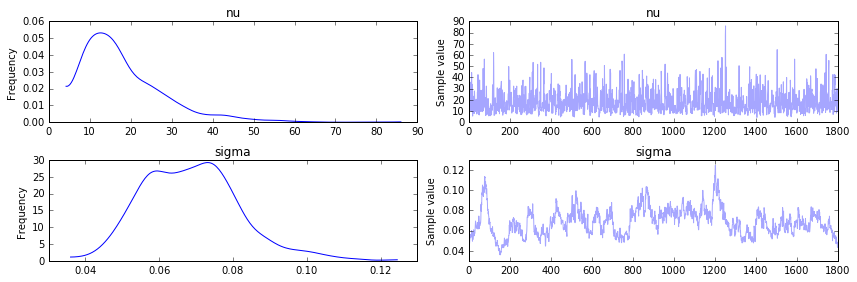

In [5]:
from pymc3 import traceplot

traceplot(trace[200:], [nu, sigma]);


Finally we plot the distribution of volatility paths by plotting many of our sampled volatility paths on the same graph. Each is rendered partially transparent (via the alpha argument in Matplotlib’s plot function) so the regions where many paths overlap are shaded more darkly.



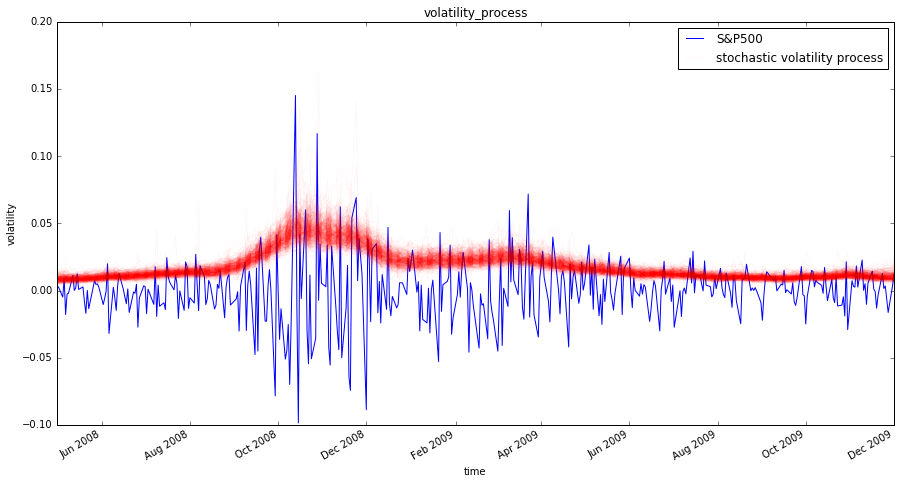

In [7]:
import numpy as np

fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

As you can see, the model correctly infers the increase in volatility during the 2008 financial crash. Moreover, note that this model is quite complex because of its high dimensionality and dependency-structure in the random walk distribution. NUTS as implemented in PyMC3, however, correctly infers the posterior distribution with ease.

### Example3: 


##### References

1. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo (18 Nov 2011) https://arxiv.org/abs/1111.4246
2. Automatic Differentiation Variational Inference (2 Mar 2016) https://arxiv.org/abs/1603.00788
3. Bayesian Inference for Hackers http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/
4. Probabilistic programming in Python using PyMC3 https://peerj.com/articles/cs-55/
5. Fast Forward Labs http://blog.fastforwardlabs.com/tagged/probabilistic-programming